# 2020-05-11

## Learning curve fitting

I need to fit gaussians to 3D images. Towards this, I'm going to learn about curve-fitting in python. Hopefully I can figure out how to extend this to 3D...

Good tutorial I'm working from: https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

### Fitting exponential

In [2]:
# Make a function that returns exponential from data x and parameters a and b.
def exponential(x, a, b):
    y = a * np.exp(b * x)
    return y

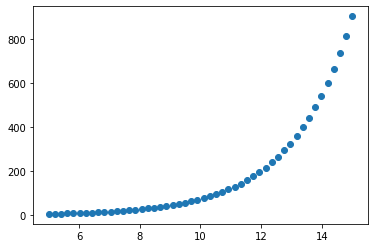

In [4]:
# Generate dummy dataset
x_dummy = np.linspace(start=5, stop=15, num=50)
# Calculate y-values based on dummy x-values
y_dummy = exponential(x_dummy, 0.5, 0.5)
plt.scatter(x_dummy, y_dummy)

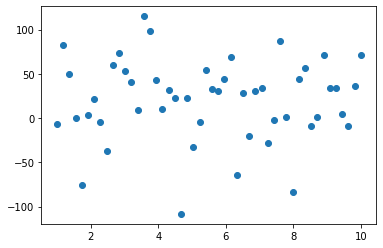

In [11]:
# Add noise from a Gaussian distribution
noise = 50*np.random.normal(size=y_dummy.size)
plt.scatter(np.linspace(1,10,y_dummy.size), noise)
y_dummy = y_dummy + noise

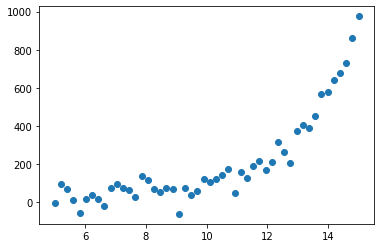

In [12]:
plt.scatter(x_dummy,y_dummy)

In [17]:
# curve_fit takes a function, f. f must take the independent variable (xdata) as its first
# argument and parameters to fit as subsequent variables.
params, cov = curve_fit(exponential, xdata=x_dummy, ydata=y_dummy, p0=[0,0], bounds=(-np.inf, np.inf))

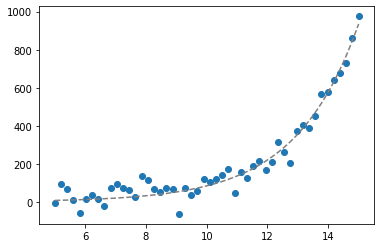

In [24]:
plt.scatter(x_dummy,y_dummy)
plt.plot(x_dummy,exponential(x_dummy,params[0], params[1]),color="gray", linestyle="--")

In [25]:
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

In [26]:
x_dummy = np.linspace(start=-10, stop=10, num=100)
y_dummy = gaussian(x_dummy, 8, -1, 3)

In [27]:
# Add noise from a Gaussian distribution
noise = 0.5*np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise

In [32]:
# Fit the dummy Gaussian data
pars, cov = curve_fit(f=gaussian, xdata=x_dummy, ydata=y_dummy, p0=[5, -1, 1], bounds=(-np.inf, np.inf))
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))
# Calculate the residuals
res = y_dummy - gaussian(x_dummy, *pars)

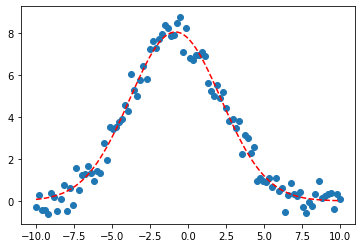

In [36]:
plt.scatter(x_dummy,y_dummy)
plt.plot(x_dummy, gaussian(x_dummy, *pars), color='red',linestyle='--')

OK I now had to go down a kinda deep-dive about multivariate gaussians. The upshot isn't complex: assume independence and just multiply them together. Here is some code from [the scipy cookbook](https://scipy-cookbook.readthedocs.io/items/FittingData.html) for fitting a 2D gaussian. Should be pretty adaptable to 3D.

__gaussian__ returns a function (not the result) that computes prob of gaussian for parameter set at a given x,y coordinate. __moments__ generates estimates of the parameters for the initial guesses (means, essentially). __fitgaussian__ develops an error function (simply the difference between the gaussian for a set of parameters and the data) and uses least squares fitting to optimize parameter set.

Pretty straightforward. I should just need to adapt this to 3D...

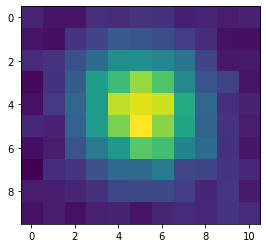

In [77]:
# Load image for testing
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import (read_tiff_folder, read_tiff_lattice, viewer, viewer)

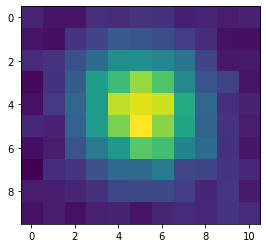

In [84]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/',
    span=(0,1))

red = stack[0,0,56]
window=red[290:300,152:163]
plt.imshow(window)

In [179]:
import numpy as np
from scipy import optimize

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def plotfit(data, p):
    a=fitgaussian(window)
    x, y = np.indices(data.shape)
    f = gaussian(*p)
    fit_window = f(x, y)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(data)
    ax[1].imshow(fit_window)
    #viewer([data, fit_window], 'xy')


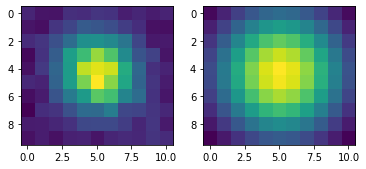

In [81]:
p=fitgaussian(window)
plotfit(window,p)

Alright let's try to 3D-ify this!

In [89]:
red = stack[0,0]
data3d=red[47:64,290:300,152:163]
viewer(data3d,'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'Reds', 'gray', 'prism', 'Gre…

In [122]:
import numpy as np
from scipy import optimize

def gaussian3d(height, center_z, center_x, center_y, width_z, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    width_z = float(width_z)
    return lambda z,x,y: height*np.exp(
                -(((center_z-z)/width_z)**2 + ((center_x-x)/width_x)**2 + ((center_y-y)/width_y)**2)/2)


In [175]:
z, x, y = np.indices(data3d.shape)
f = gaussian3d(100,8,7,3,4,1,1)
a = f(z, x, y)
viewer(a, 'zxy')

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'Reds', 'gray', 'prism', 'Gre…

Looks good! This makes a 3D gaussian.

Whoops...discovered a mistake in the code from scipy website. I couldn't figure out why they flipped the x and y in the width_x and width_y calculations (lines 10 and 12 two cells down). It turns out it's a mistake. To illustrate, I moved the center around some and tested two versions, theirs and a corrected version:

In [ ]:
# Make a 3D gaussian, a with the center at [x,y]=[7,3] and width of 1 in both directions.
z, x, y = np.indices(data3d.shape)
f = gaussian3d(100,8,7,3,4,1,1)
a = f(z, x, y)

In [184]:
def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def moments2d(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

In [182]:
moments(a[9])

(96.92332344763442,
 6.9860981717858825,
 3.0005428644790357,
 4.104483823034742,
 4.108844968765645)

In [185]:
moments_v2(a[9])

(96.92332344763442,
 6.9860981717858825,
 3.0005428644790357,
 0.980885490744013,
 0.9989774120314082)

Their version incorrectly estimates widths ~4 in both x and y. The corrected version gets it right. Useful for 3D version:

In [210]:
def moments3d(data):
    """Returns (height, z, x, y, width_z, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    # Find total for all values in the data.
    total = data.sum()
    
    # Make index matrices.
    Z, X, Y = np.indices(data.shape)
    
    # Find mean positions in each dimension by weighted average (weight is intensity, index is position)
    z = (Z*data).sum()/total
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    
    # Estimate width in each dimension. Procedure is to fix the other two dimensions at their mean
    # and retrieve a single column in the dimension of interest through the peak. Visually, in a Z-
    # stack you would determine the X,Y position of the center of the peak, then we're drawing a line
    # (or a bar) in Z through that point. This becomes a simple 1D profile of intensity as a function
    # of Z position. Standard deviation of this 1D vector about z (mean Z position) is computed.
    z_col = data[:, int(x), int(y)] #single column through z with x and y fixed at their means.
    width_z = np.sqrt(np.abs((np.arange(z_col.size)-z)**2*z_col).sum()/z_col.sum())
    x_col = data[int(z), :, int(y)] #single column through x with z and y fixed at their means.
    width_x = np.sqrt(np.abs((np.arange(x_col.size)-x)**2*x_col).sum()/x_col.sum())
    y_col = data[int(z), int(x), :] #single column through y with z and x fixed at their means.
    width_y = np.sqrt(np.abs((np.arange(y_col.size)-y)**2*y_col).sum()/y_col.sum())
    
    # Estimator height from max value.
    height = data.max()
    return height, z, x, y, width_z, width_x, width_y

In [232]:
# Correct answer is: (100,8,7,3,4,1,1)
moments3d(a)

(100.0,
 8.0,
 6.986098171785882,
 3.000542864479035,
 3.6162814296060555,
 0.980885490744013,
 0.9989774120314082)

Two down, one to go:

In [229]:
def fitgaussian(data):
    """Returns (height, z, x, y, width_z, width_x, width_y)
    the gaussian parameters of a 3D distribution found by a fit"""
    params = moments3d(data)
    errorfunction = lambda p: np.ravel(gaussian3d(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def plotfit3d(data):
    p=fitgaussian(data)
    x, y, z = np.indices(data.shape)
    f = gaussian3d(*p)
    fit = f(x, y, z)
    #fig, ax = plt.subplots(1,2)
    viewer([data, fit], 'zxy')


In [215]:
fitgaussian(a)

array([100.,   8.,   7.,   3.,   4.,   1.,   1.])

In [216]:
fitgaussian(data3d)

array([615.0762059 ,   6.5360248 ,   4.48668599,   5.21713088,
         9.27639652,   4.1883005 ,   4.19040238])

In [230]:
plotfit3d(data3d)

interactive(children=(Dropdown(description='Color', index=9, options=('cividis', 'Reds', 'gray', 'prism', 'Gre…

Aha! I didn't have to mod fitgaussian at all. That's terrific. One thing to note is that the closer in I focus on the spot, the better the fit gets, particularly wrt the height. With a wider window, the peak is always too low. This of course makes sense but worth thinking about...

Ok I'm gonna put these into a new module for fitting. I may change this around in future and include it in image processing but it seems like it could be its own thing. Commented up functions that I added to the module __fitting.py__:

In [233]:
import numpy as np
from scipy import optimize
############################################################################

def gaussian3d(height, center_z, center_x, center_y, width_z, width_x, width_y):
    """Returns a 3D gaussian function with the given parameters
    
    Args:
        height: int
            Height of the gaussian
        center_z, center_x, center_y: int
            Locations of the center of the gaussian
        width_z, width_x, width_y: int
            Sigmas for the gaussians in each dimension
    
    Returns:
        Function that accepts int coordinates z,x,y and returns the value of
        the 3D gaussian function at that position based on input parameters.
    """
    width_x = float(width_x)
    width_y = float(width_y)
    width_z = float(width_z)
    return lambda z,x,y: height*np.exp(
                -(((center_z-z)/width_z)**2 + 
                  ((center_x-x)/width_x)**2 + 
                  ((center_y-y)/width_y)**2)/2)

############################################################################
def moments3d(data):
    """Estimate initial parameters of 3D gaussian fit
    
    Returns (height, z, x, y, width_z, width_x, width_y)
    the gaussian parameters of a 3D distribution by calculating its
    moments (mean for centers, standard deviation for widths) 
    
    Args:
        data: ndarray
            The 3D data to fit in shape [z,x,y]
    Returns:
        tuple of ints
            Estimates for intial fit params: (height, z, x, y, width_z,
            width_x, width_y)   
    """
    # Find total for all values in the data.
    total = data.sum()
    
    # Make index matrices.
    Z, X, Y = np.indices(data.shape)
    
    # Find mean positions in each dimension by weighted average (weight is intensity, index is position)
    z = (Z*data).sum()/total
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    
    # Estimate width in each dimension. Procedure is to fix the other two dimensions at their mean
    # and retrieve a single column in the dimension of interest through the peak. Visually, in a Z-
    # stack you would determine the X,Y position of the center of the peak, then we're drawing a line
    # (or a bar) in Z through that point. This becomes a simple 1D profile of intensity as a function
    # of Z position. Standard deviation of this 1D vector about z (mean Z position) is computed.
    z_col = data[:, int(x), int(y)] #single column through z with x and y fixed at their means.
    width_z = np.sqrt(np.abs((np.arange(z_col.size)-z)**2*z_col).sum()/z_col.sum())
    x_col = data[int(z), :, int(y)] #single column through x with z and y fixed at their means.
    width_x = np.sqrt(np.abs((np.arange(x_col.size)-x)**2*x_col).sum()/x_col.sum())
    y_col = data[int(z), int(x), :] #single column through y with z and x fixed at their means.
    width_y = np.sqrt(np.abs((np.arange(y_col.size)-y)**2*y_col).sum()/y_col.sum())
    
    # Estimator height from max value.
    height = data.max()
    return height, z, x, y, width_z, width_x, width_y

############################################################################
def fitgaussian(data, return_viewable=False):
    """Fit a gaussian
    
    Returns (height, z, x, y, width_z, width_x, width_y)
    the gaussian parameters of a 3D distribution found by a least squares 
    fit. Wrote for 3D, but will work for 2D.
    
    Args:
        data: ndarray
            The 3D data to fit in shape [z,x,y]
    Returns:
        tuple of ints
            Parameters of the fit: (height, z, x, y, width_z, width_x, width_y)
    
    """
    
    params = moments3d(data)
    # Error function is simple difference between gaussian function and data.
    errorfunction = lambda p: np.ravel(gaussian3d(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)

    return p